# Visualizing Twitter Communities Over the Ferguson Shooting
A popular method of visualizing data from twitter is to use community mapping techniques through node graphs. A node represents an individual - these will be represented as circles. An edge, or connecting line between nodes, represents for our data a retweet connection. In these representation one can understand information propogation during an event and the amount that differing sides/opinions interact through information promotion on social media - a potential indicator of conversation. 

## Imports

Before we get started, let's get everything uploaded. We are using a few speciality packages for this visualization notebook including plotly, basemap, networkx, and cartopy. 

To download plotly using the command line, simply use the command `pip install plotly` in your terminal. Similarly, networkx can be installed with `pip install networkx`. For basemap, we recommend following the instructions [here](http://matplotlib.org/basemap/users/installing.html). And last, for cartopy, you can simply use the pre-built package for Anaconda using `conda install -c scitools cartopy`. 


In [2]:
% matplotlib inline
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime

#for matplotlib maps
import cartopy.crs as ccrs
from ipywidgets import widgets
import matplotlib.cm as cm

#for animation maps
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile

#for the node graphs
import networkx as nx

#for the node graphs maps
from mpl_toolkits.basemap import Basemap
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('vpreston', 'tcx2wn8rfb')

#making the visualizations interactive
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot
from plotly.graph_objs import Scatter
init_notebook_mode()

## What are Communities Anyway?
Within the world of network analysis, the term "communities" is used to describe the idea that people are connected to one another in a (social) pattern with certain, quanitifiable attributes which can be mapped. There are various methodologies for determining the presence of a community analytically - these techniques often use the concepts of centrality, classifying, connectivity, and many more to identify subgroups. These communities can also be qualitatively observed through a data visualization technique called network node-edge graphs.

## The Data to Visualize
Let's first grab data from the first dataset, herein the "shooting" dataset so named because the data is the first two weeks of twitter data related to the Ferguson shooting (and not the indictment).

In [3]:
def ReadToDf(linesAtATime,filepath, max=-1):
    start = time.time()
    df = pd.DataFrame()
    i = 0
    data = [] 
    
    #Open and read in the file
    with open(filepath) as cleanedTweets:
        for tweet in cleanedTweets:
            i += 1
            jsonline = json.loads(tweet)
            data.append(jsonline)
            #aggregate once we've read in the appropriate number of liens
            if (i % linesAtATime == 0):
                print "number of tweets parsed: ", i
                print "total time elapsed: ", time.time() - start
                df = df.append(pd.DataFrame(data=data))
                #reset the data
                data = []
        #Allow us to handle the last few tweets, and to truncate the data if we just want to run unit tests
            if (max > 0 and i >= max):
                break
        df = pd.DataFrame(data=data).append(df)
    #return the aggregation
    return df

In [4]:
df = ReadToDf(100000, 'data/cleanedShootingTweets.json',max=500000)

number of tweets parsed:  100000
total time elapsed:  5.09561610222
number of tweets parsed:  200000
total time elapsed:  10.4655101299
number of tweets parsed:  300000
total time elapsed:  16.2270290852
number of tweets parsed:  400000
total time elapsed:  22.7011840343
number of tweets parsed:  500000
total time elapsed:  29.3895611763


In order to later do some interesting network mapping, we will recode the `coordinate` and `place` columns into true latitude and longitude values.

In [5]:
def get_coordinates(x):
    try:
        res = x.get('coordinates')
    except:
        res = [None,None]
    return res

def get_place(x):
    try:
        box = x.get('coordinates')
        mean_coord_x = (box[0][0][0]+box[0][1][0]+box[0][2][0]+box[0][3][0])/4
        mean_coord_y = (box[0][0][1]+box[0][1][1]+box[0][2][1]+box[0][3][1])/4
        res = [mean_coord_x,mean_coord_y]
    except:
        res = [0,0]
    return res

In [6]:
df['Coords'] = df['coordinates'].apply(get_coordinates)
df['P_Coords'] = df['place'].apply(get_place)

df['x'] = df['Coords'].apply(lambda x: x[0])
df['y'] = df['Coords'].apply(lambda x: x[1])

df['x_p'] = df['P_Coords'].apply(lambda x: x[0])
df['y_p'] = df['P_Coords'].apply(lambda x: x[1])

df['x'].fillna(df['x_p'], inplace = True)
df['y'].fillna(df['y_p'], inplace = True)

## Building Context 
The Ferguson Shooting refers to the shooting and killing of Michael Brown, a black teenager from the St. Louis suburb, by a white police officer, Darren Wilson. The event, one amongst recent slayings of black teenage men by white police, instilled local unrest and sparked a truly international conversation virtually. 

Twitter, as a social media utility, allows users to post 140 character messages to "followers" which are other users of the application which have elected to receive the posts of the original user. Hashtags, a quippy phrase marked with a pound sign, are used to flag the content of these messages. Further, messages can be "retweeted." In this way Twitter is an exciting social media source to analyze for networks and information propogation flow. 

Using hashtags as a means of sorting tweets to visualize them may yield compelling results. Further, understanding geographic information flow may also yield interesting patterns.

## Information Propogation
Let's begin with a visualization that simply maps out a network of users.

For ease of data handling, we create a new dataframe which contains the information we care about including location, user identity, retweeter identity, and the hashtags used.

In [7]:
retweetRows = []
for i,tweet in df.iterrows():
    for retweeter in tweet['entities_user_mentions_screen_name']:
        mappeduser = retweeter.upper()
        retweetRows.append({
                'retweeter': mappeduser,
                'tweetId': tweet['user_screen_name'].upper(),
                'x': tweet['x'],
                'y': tweet['y'],
                'retweet_count': tweet['retweet_count'],
                'entities_hashtags_text': tweet['entities_hashtags_text'],
            })
print "creating dataframe"
retweetDf = pd.DataFrame(retweetRows)

creating dataframe


Using the networkx package and matplotlib, we can quickly get a sense of the tweet network.

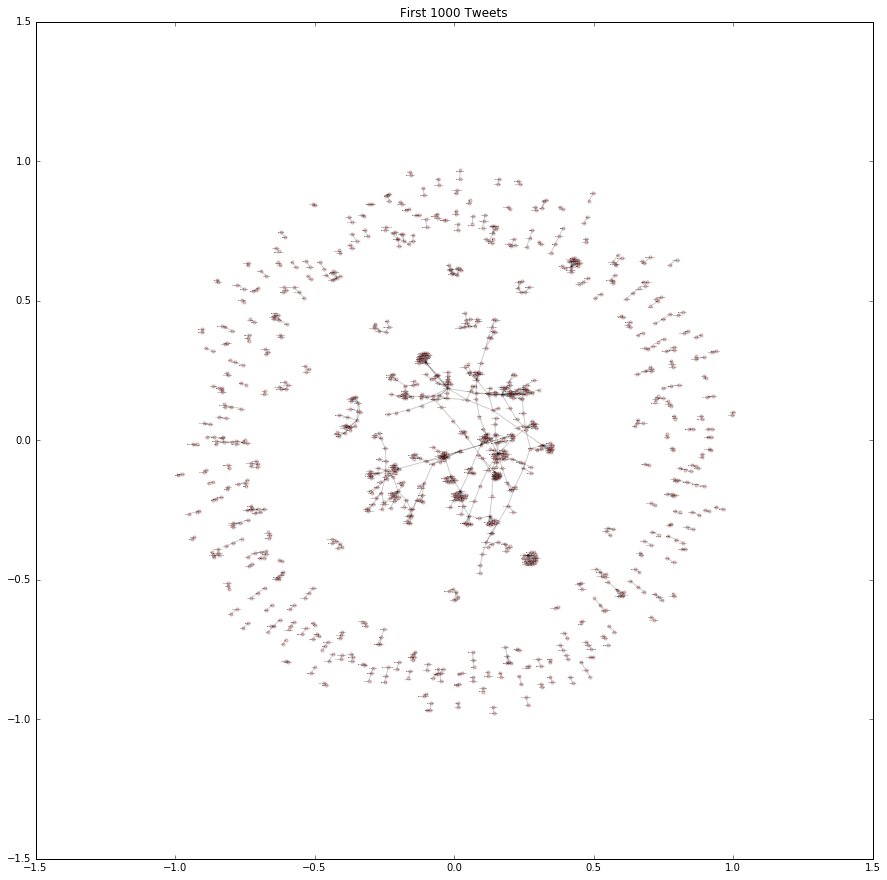

In [9]:
plt.figure(figsize=(15,15))

G=nx.from_pandas_dataframe(retweetDf[0:1000:], source='tweetId',target='retweeter')

nx.draw_networkx(G,alpha=0.2,font_size=0, node_size=10)
plt.title('First 1000 Tweets')
plt.axis('equal')
plt.show()

Central to this graph layout is the largest connected network. Clusters imply closely related users and terminations in the transmission chain. The ring of small chains shows a disconnect from the central network. Given that this is an extremely small subset of the data, and consecutive, it perceptively makes sense that there would be a large central network - the event needs to be communicated in some way, and whomever breaks the news would be likely to be retweeted. 

Sampling thus is extremely important for drawing networks. To compare, look at this network graph of non-consecutive tweets:

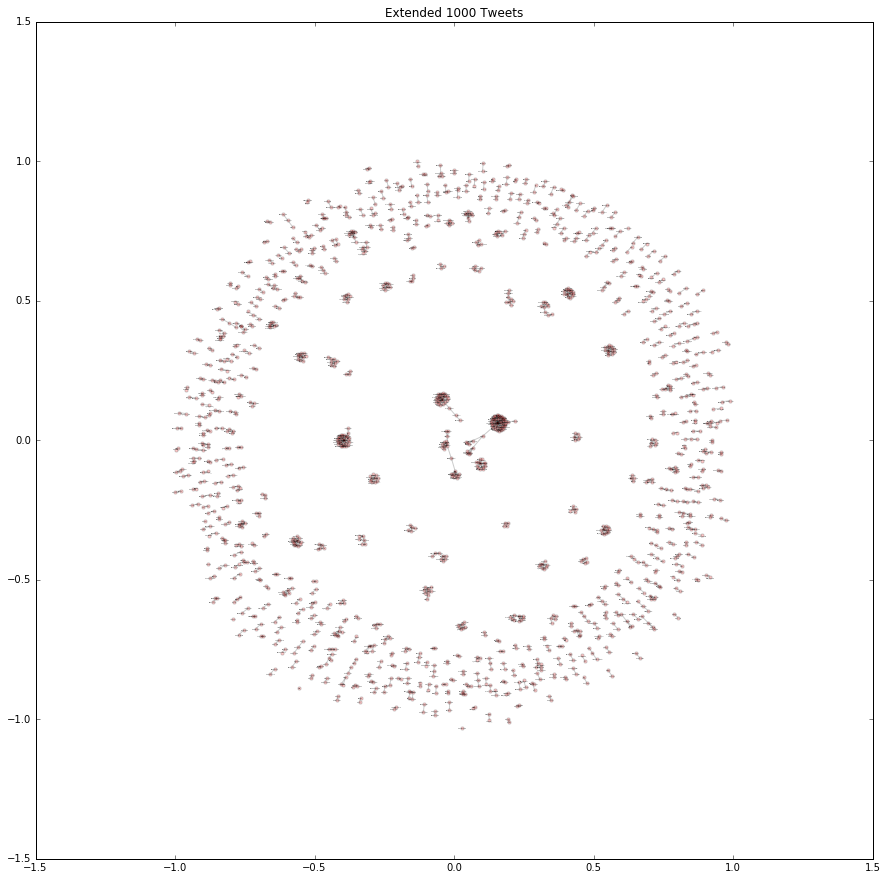

In [10]:
plt.figure(figsize=(15,15))

G=nx.from_pandas_dataframe(retweetDf[0:500000:500], source='tweetId',target='retweeter')

nx.draw_networkx(G,alpha=0.2,font_size=0, node_size=10)
plt.title('Extended 1000 Tweets')
plt.axis('equal')
plt.show()

Here we see more distinctly that there are more dense communities which may persistently communicate over the event, with central or breaking information being more widely shared, as indicated in the first visualization. This is also an important consideration when developing more intensive network visualizations.

## Individual Impact and Visualizing Centrality
There are clear leaders in any conversation, and this is observable in the network by simply allowing certain parameters of the visualization to be leveraged. Size and color are two of these features. 

### Helper Functions for Node Visualizations
We'll be using plotly as the way to visualize the rest of these graphs, for its extremely versatile and interactive interface. As part of this, we'll need to create special graphing features for the interface. 

In [14]:
#create empty scatter objects for nodes and edges

def init_edge():
    edge_trace = Scatter(
    x=[], 
    y=[], 
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
    return edge_trace

def init_node(size=[],color=[]):
    node_trace = Scatter(
    x=[], 
    y=[], 
    text=[],
    mode='markers', 
    hoverinfo='text',
    marker=Marker(
        color=color, 
        size=size,         
        line=dict(width=0.5)))
    return node_trace

def make_figure(data1, data2, title):
    fig = Figure(data=Data([data1, data2]),
             layout=Layout(
                title=title,
                titlefont=dict(size=16),
                showlegend=False, 
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
    return fig

### Size as Centrality Visualization

In [16]:
#create the graphing node from the dataframe
G=nx.from_pandas_dataframe(retweetDf[0:300000:100], source='tweetId',target='retweeter')

#select a layout model
pos = nx.spring_layout(G)

#using the layout model, assign positions of each user in the visualization
for n,p in pos.iteritems():
    G.node[n]['pos'] = p

#create an empty scatter object to populated with edge information
edge_trace = init_edge()

#populate the edge scatter object
for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

#create an empty scatter object to populate with node information
node_trace = init_node(color='blue')

#populate the node scatter object
for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['text'].append(str(node))

#use the adjacency attribute to count the number of connections a node has, then map that to the size
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['size'].append(len(adjacencies))

#create the figure object
fig = make_figure(edge_trace, node_trace, '<br>The Network: Size as Centrality')

#plot using the offline plotly system
iplot(fig)

Strikingly, Antonio French immediately stands out. This figure happens to be critical in the events that unfolded following Michael Brown's death. He is an Alderman in St. Louis, and in the 2014 unrest that followed the shooting, was an outspoken advocate, and was arrested during his time covering events in Ferguson. 

### Color as a Measure of Centrality

In [19]:
#create the graphing node from the dataframe
G=nx.from_pandas_dataframe(retweetDf[0:300000:100], source='tweetId',target='retweeter')

#select a layout model
pos = nx.spring_layout(G)

#using the layout model, assign positions of each user in the visualization
for n,p in pos.iteritems():
    G.node[n]['pos'] = p

#create an empty scatter object to populated with edge information
edge_trace = init_edge()

#populate the edge scatter object
for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

#create an empty scatter object to populate with node information
node_trace = init_node(size=10)

#populate the node scatter object
for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['text'].append(str(node))

#use the adjacency attribute to count the number of connections a node has, then map that to the size
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))

#create the figure object
fig = make_figure(edge_trace, node_trace, '<br>The Network: Color as Centrality')

#plot using the offline plotly system
iplot(fig)

It is still clear that Antonio French is still the center of information, but the extent to which he has impacted the network is lost. This is further an important consideration in visualization. Color is a great sorting metric, and in the next section we explore that quality by looking at hashtag networks.

## Identifying Communities
Through color coding of hashtags, we can determine whether there are community relationships or discussions which exist primarily between certain aligning perspectives, or whether there was an even amount of cross-pollination between groups.

To begin, let's create a mapping of popular hashtags that align with supporters of Michael Brown and family, and supporters of Darren Wilson and the police. Then using this mapping, let's create a new data frame we can manipulate.

In [30]:
hashtagMapBlue = ['MIKEBROWN','JUSTICEFORMIKEBROWN','HANDSUPDONTSHOOT',
                  'DONTSHOOT','CRIMEBUTNOTIME','POLICEBRUTALITY',
                  'P2','BEFREE','MIKEBROWNRALLY',
                  'STANDWITHFERGUSON','BLACKLIVESMATTER','OCCUPYFERGUSON',
                  'POLICESTATE','WHITEPRIVILEGE','IFTHEYGUNNEDMEDOWN',
                  'HANDSUP','NOJUSTICENOPEACE','WEGOTYOUSIS',
                  'RACISM','CIVILRIGHTS','FERGUSONCOVERUP',
                  'MIKEBROWNBHEARD','BLACKTWITTER','TRAYVONMARTIN',
                  'NMOS14','COPSLIE','NOJUSTICENOSLEEP',
                  'FTP','WHEREISDARRENWILSON','ARRESTDARRENWILSON','UNITEBLUE', 'TLOT']

hashtagMapRed = ['TCOT','DARRENWILSON',
                 'GOP','WARONWHITES','REDNATIONRISING',
                 'TGDN','PJNET','2A',
                 'FOXNEWS','CAPTRONJOHNSON','BUNDYRANCH',
                 'CCOT','LNYHBT','NRA']

In [31]:
#set up for data frame
retweetHT_Rows = []
tally_red = 0
tally_blue = 0

#want to count the number of hashtags someone has used, and whatever type of hashtags are most prevalent, that person will get that designation
for i,tweet in retweetDf.iterrows():
    #look at the hashtags and sort them
    for hashtag in tweet['entities_hashtags_text']:
        mappedhashtag = hashtag.upper()
        if (mappedhashtag in hashtagMapRed):
            tally_red += 1
        if (mappedhashtag in hashtagMapBlue):
            tally_blue += 1
    #determine person's alignment
    if tally_red > tally_blue:
        mappedhashtag = 'red' #we use colors for the mapping
    elif tally_blue > tally_red:
        mappedhashtag = 'blue' 
    else:
        mappedhashtag = 'green'
    #reset the tallies
    tally_red = 0
    tally_blue = 0
    #make a dataframe row
    retweetHT_Rows.append({
            'hashtag': mappedhashtag,
            'tweetId': tweet['tweetId'],
            'x': tweet['x'],
            'y': tweet['y'],
            'retweeter': tweet['retweeter'],
        })
            
print "creating dataframe"
retweetHashtagsDf = pd.DataFrame(retweetHT_Rows)

creating dataframe


Now, let's visualize the network now with this coloration.

In [52]:
#create the graphing node from the dataframe
G=nx.from_pandas_dataframe(retweetHashtagsDf[0:300000:100], source='tweetId',target='retweeter')

#select a layout model
pos = nx.spring_layout(G)

#using the layout model, assign positions of each user in the visualization
for n,p in pos.iteritems():
    G.node[n]['pos'] = p

#create an empty scatter object to populated with edge information
edge_tracer = init_edge()

#populate the edge scatter object
for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_tracer['x'] += [x0, x1, None]
    edge_tracer['y'] += [y0, y1, None]

#create a dictionary for color look-up to plot
color = {}
for i,tweet in retweetHashtagsDf.iterrows():
    color[tweet['tweetId'].upper()] = tweet['hashtag']
    color[tweet['retweeter'].upper()] = tweet['hashtag']

#create an empty scatter object to populate with node information
node_tracer = init_node(color=[],size=[])

#populate the node scatter object
for node in G.nodes():
    x, y = G.node[node]['pos']
    node_tracer['x'].append(x)
    node_tracer['y'].append(y)
    node_tracer['text'].append(str(node))
    node_tracer['marker']['color'].append(color.get(node))

#use the adjacency attribute to count the number of connections a node has, then map that to the size
for node, adjacencies in enumerate(G.adjacency_list()):
    node_tracer['marker']['size'].append(len(adjacencies))

#create the figure object
fig = make_figure(edge_tracer, node_tracer, '<br>The Network: Hashtag Communities')

#plot using the offline plotly system
iplot(fig)

[]


In this we see that the more supportive of Michael Brown and family, or even neutral, parties are seeing more traction. But we also see that there are very few non-supporters in that network. Rather, it appears that there are more individual communities of these Darren Wilson supporters, implying that there might not be significant cross talk between these groups.

## Mapping Networks
The placement of nodes in these previous graphs was based upon a spring model - there is some attraction between nodes which are "closer together" and no attraction between those that are further apart. This dataset also has an explicit position mapping through geographic coordinates. Mapping these networks physically could further yield insight about communities. 

To do this, we simply replace our position model layout with a dictionary of position coordinates from the data frame. First, we'll make a new dataframe with only populated coordinate data.

In [53]:
latLonPopulated_RTHT = retweetHashtagsDf[(retweetHashtagsDf['x'] != 0) & (retweetHashtagsDf['y'] != 0)]

pos = {}
for i,tweet in latLonPopulated_RTHT.iterrows():
    pos[tweet['tweetId'].upper()] = np.asarray([tweet['x'],tweet['y']])
#     pos[tweet['retweeter'].upper()] = np.asarray([tweet['x'],tweet['y']])

We'll also need to set-up a map for reference behind the frame. Code for this is adapted from tutorials provided by matplotlib, plotly, and basemap.

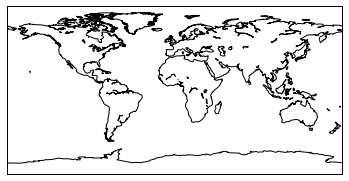

In [54]:
#again, code adapted from https://plot.ly/ipython-notebooks/basemap-maps/

#just rename the module for ease
m = Basemap()

#just like before, we need to make a scatter frame
def make_scatter(x,y):
    return Scatter(x=x,
                   y=y,
                   mode='lines',
                   line=Line(color='black'),
                   name=' ')

#this breaks down attributes of the baseline map and allows us to convert it to a scatter object for plotting
def polygons_to_traces(poly_paths, num_paths):
    #polypaths - the data to trace
    #num_paths - the number of contours to actually trace (since there are a lot)
    traces = []  

    for i in range(num_paths):
        poly_path = poly_paths[i]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)])
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
        
        # make the plotly data
        traces.append(make_scatter(lon_cc,lat_cc))
     
    return traces

def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    return polygons_to_traces(poly_paths, N_poly)

#actually create the contour traces for the map
traces_cc = get_coastline_traces()

Further, given the scale of the map, we will plot the log-normalized sizes in order to have an opportunity to more closely examine locations of opinion (should they exist).

In [59]:
G=nx.from_pandas_dataframe(latLonPopulated_RTHT, source='tweetId',target='retweeter')

#create the specialized position matrix
pos = {}
color = {}
for i,tweet in latLonPopulated_RTHT.iterrows():
    pos[tweet['tweetId'].upper()] = np.asarray([tweet['x'],tweet['y']])
    pos[tweet['retweeter'].upper()] = np.asarray([tweet['x'],tweet['y']])
    color[tweet['tweetId'].upper()] = tweet['hashtag']
    color[tweet['retweeter'].upper()] = tweet['hashtag']

for n,p in pos.iteritems():
    G.node[n]['pos'] = p

pos = nx.get_node_attributes(G,'pos')

edges = init_edge()

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edges['x'] += [x0, x1, None]
    edges['y'] += [y0, y1, None]

nodes = init_node(color=[],size=[])

for node in G.nodes():
    x, y = G.node[node]['pos']
    nodes['x'].append(x)
    nodes['y'].append(y)
    nodes['marker']['color'].append(color.get(node))
    nodes['text'].append(str(node))

for node, adjacencies in enumerate(G.adjacency_list()):
    nodes['marker']['size'].append(np.log(len(adjacencies))*10) #making the log normal sizing here


fig = Figure(data=Data([edges, nodes]+traces_cc), #not using specialized function here because of map tracing
             layout=Layout(
                title='<br> A Physical Mapping of the Network',
                titlefont=dict(size=16),
                showlegend=False, 
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(range=[-180,180],showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(range=[-75,75],showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

What is striking about the map of the world is the spread of information outside of the United States. Zooming in to the country, we see immediately three nodes of officer-based support - Baltimore, a site of frequent white officer-black teen altercations and killings, being amongst these. A mapping like this allows us to immediately see the epicenter of the tweets - Ferguson - and the relationship of opinion, politics, and location. 

## Conclusions and Future Work in Networking
There is some obvious power in the various ways to visualize and leverage the attributes of a network graph to discuss social media, information spread. With further work - particularly in starting to develop analytical methods of defining communities and classifying information flow, adding external event data, etc - it may be possible to use network theory to start to analyze present versus virtual activism in social justice movements. This has far reaching impacts from informing groups like BlackLivesMatter on how to reach previously untapped communities, to mobilizing groups across the country. Even at the time of Ferguson, Twitter became a venue for memoralizing other young people who's lives were taken by police shootings, for supporting rallies in Los Angeles, and for truly real-time international reporting. In an increasingly connected world, we should learn what that means; we see potential here to begin that process.